In [65]:
import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod


#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed

In [66]:
# Create the parser
parser = argparse.ArgumentParser(description="Process some parameters for clustering.")
# Add required arguments
parser.add_argument("Ncores", type=int, help="Number of CPU's")
parser.add_argument("file_path", type=str, help="Path to the file")
parser.add_argument("geo_file_path", type=str, help="Path to the file")
parser.add_argument("parent_directory", type=str, help="Parent directory")
parser.add_argument("results_directory", type=str, help="Results directory")
parser.add_argument("tmin", type=int, help="Minimum time")
parser.add_argument("tmax", type=int, help="Maximum time")
parser.add_argument("lat_resolution", type=float, help="Lat resolution for the IC grid in degrees")
parser.add_argument("lon_resolution", type=float, help="Lon resolution for the IC grid in degrees")
parser.add_argument("dt", type=float, help="Time step size for Runge Kutta")
parser.add_argument("DT", type=float, help="Time step size for Fmap")
parser.add_argument("geodesic", type=lambda x: x.lower() == 'true', help="Geodesic boolean for trajectory distance")
# Add optional argument with a default value
parser.add_argument("--freq", type=int, default=10, help="Frequency (default: 10)")
parser.add_argument("--K", type=int, default=1000, help="K similarity diagonal (default: 1000)")
parser.add_argument("--n_clusters", type=int, default=0, help="Number of clusters (default: 0 which gives the default number)")
parser.add_argument("--e", type=float, default=0, help="Sparsification parameter (default: 0 which translates to standard deviation)")
# Parse the arguments
args = parser.parse_args()


Ncores = args.Ncores
file_path = args.file_path
geo_file_path = args.geo_file_path
parent_directory = args.parent_directory
results_directory = args.results_directory
tmin = args.tmin
tmax = args.tmax
lat_resolution = args.lat_resolution
lon_resolution = args.lon_resolution
dt = args.dt
DT = args.DT
geodesic = args.geodesic
freq = args.freq
K = args.K
n_clusters = args.n_clusters
e = args.e
k_exp = 20

if not os.path.exists(results_directory):
    os.makedirs(results_directory)

In [ ]:

"""
K=1000
Ncores = 10
geo_file_path = "/home/llu/Data/OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_latlon_rot_jacob.nc"
parent_directory = "/home/llu/Programs/HPC_Spectral_Clustering/"
tmin = 0
tmax = 360
lat_resolution = 0.25
lon_resolution = 0.25
dt = 1
DT = 10
freq = 1
timemod = int(DT/dt) #10
geodesic=False
n_clusters=0
e=0
k_exp = 20

# Initial file path
file_path = "/home/llu/Data/Fmap_tmin0_tmax360_latlonres0.25x0.25_dt1_DT10/"
# Construct results directory path
results_directory = f"{file_path}/{Cluster_params}/"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
    
"""




In [67]:
Cluster_params = (
    f"geodesic_{geodesic}_"
    f"nclusters{n_clusters}_"
    f"e{e}"
)

W_params = (
    f"geodesic_{geodesic}"
)



In [68]:
# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")


from ipynb.fs.defs.from_similarity_to_eigen import from_similarity_to_eigen

from ipynb.fs.defs.ploters import ini_final_clusters
from ipynb.fs.defs.ploters import gif_clusters
from ipynb.fs.defs.ploters import ini_final_clusters_landmask
from ipynb.fs.defs.ploters import gif_clusters_landmask


In [69]:
print("Reading data")
#Read input data
Fmap_path = file_path+'/Fmap_matrix.npy'
time_path = file_path+'/advection_time.npy'
W_path = file_path+'/W_matrix_'+W_params+'.npy'

# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
Fmap=Fmap[:,:,::100]
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)
# Load the similarity matrix
W_vec = np.load(W_path)

dataset = nc.Dataset(geo_file_path, mode='r')

#from m/s to m/day
siu = dataset.variables['vlon'][0,:,:]
land_mask=siu[:,:].mask

# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]

dataset.close()


Reading data


Computing the eigenvalues
The percentage of spercified elements is 0.06232812789542471
[]
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 20 eigenvalues
k_means clustering
The default number of clusters is 8


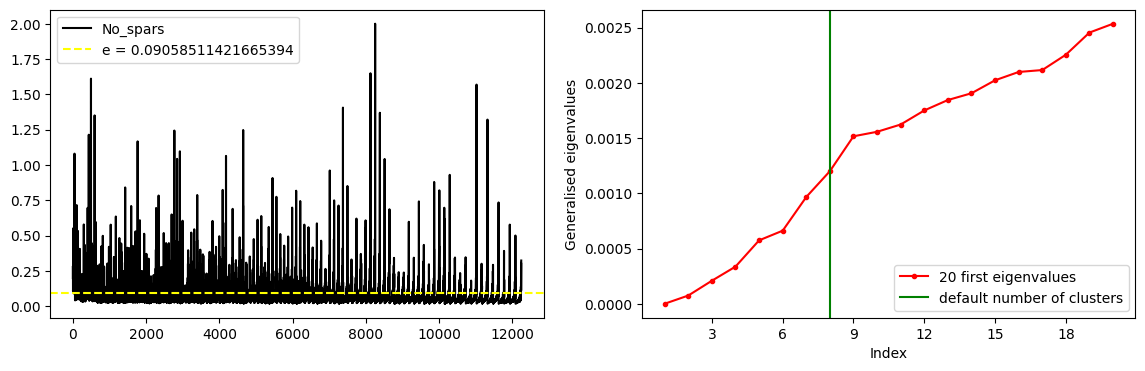

In [70]:
print("Computing the eigenvalues")
if e==0:
    e = np.std(W_vec[W_vec<999])


fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(W_vec[W_vec<999], color = 'black', label="No_spars")
axes[0].axhline(y=e, color='yellow', linestyle='--', label=f'e = {e}')
axes[0].legend()

l_vect,l,Fmap,n_clusters_def = from_similarity_to_eigen(Fmap, W_vec, e, K, k_exp)

lx = np.arange(1, len(l) + 1)
axes[1].plot(lx,l,marker='.',color='red',label=str(k_exp)+" first eigenvalues")
axes[1].axvline(x=n_clusters_def, color="green",label="default number of clusters")
axes[1].legend()
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Generalised eigenvalues")
plt.show
plt.savefig(results_directory+"eigenvalues_"+Cluster_params+".png")

### Clustering

In [71]:
print("Applying k-means to define the clusters")
if n_clusters==0:
    n_clusters = n_clusters_def  
l_vect = l_vect[:,0:n_clusters]
kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=100,max_iter=1000)
kmeans.fit(l_vect)
labels = kmeans.labels_

np.save(results_directory+'/Clusters_labels_'+Cluster_params+'.npy', labels)
np.save(results_directory+'/Fmap_'+Cluster_params+'.npy', Fmap)

Applying k-means to define the clusters


Plotting the clusters


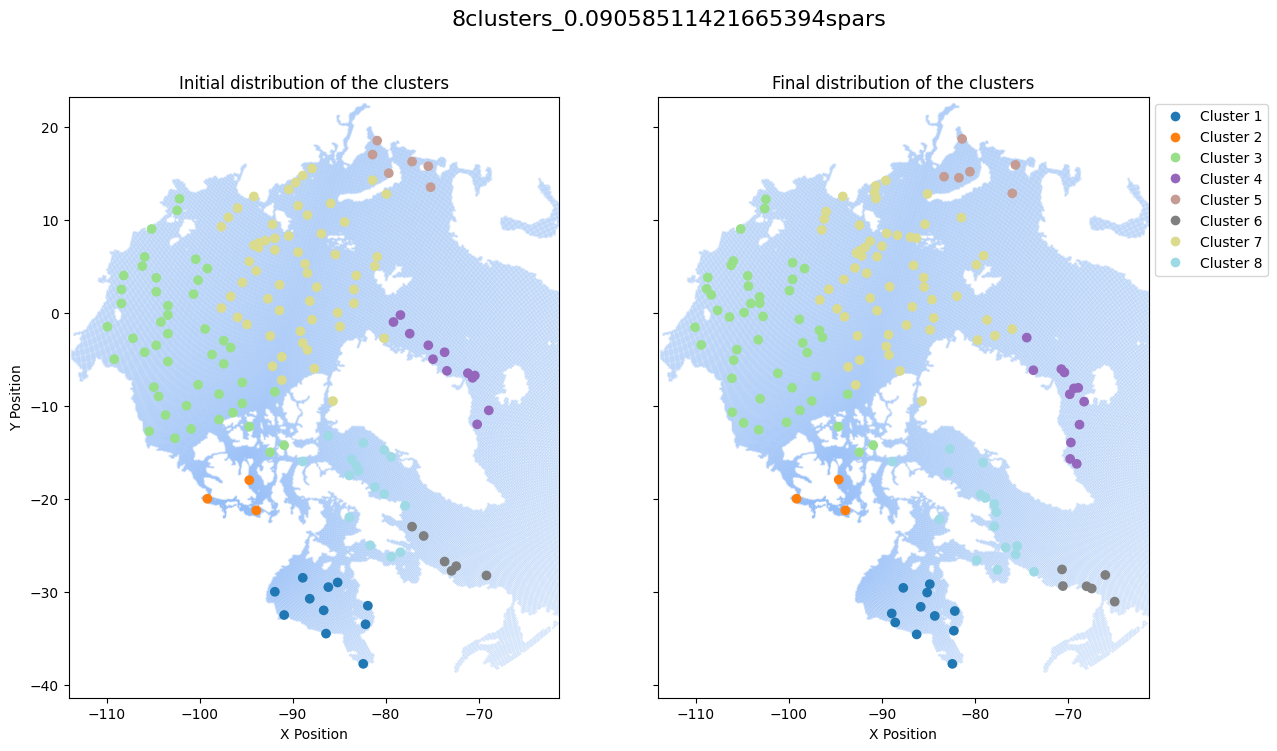

In [72]:
print("Plotting the clusters")
#ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+".png", e, longitude, latitude, land_mask)

In [73]:
print("Ploting the cluster's gif")
#gif_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+".gif", e, longitude, latitude, land_mask,10)

Ploting the cluster's gif
